In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import os
import xarray as xr
import numpy as np
import natsort
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
function_path = './functions/'
sys.path.append(function_path)
from model_analysis_function import *
from obs_function import *

In [4]:
file_path = '/Volumes/Backup Plus/Global_regional_attribution/input_data/'
file_name = '0.6large_ensembles.320runs.1850-2100.2.5deg.Grids.Anom.1961-1990.pkl'

ln_grid = pd.read_pickle(file_path + file_name).rename({'time':'year'})
ln_grid = fill_missing_lon177_5(ln_grid)
ln_grid

In [ ]:
ln_ar6_cont_global = mod_runs_ar6_cont_glob_cal(ln_grid)
ln_ar6_cont_global
### need about 1m 40s

In [44]:
### Model CESM2, the value of year 1850 is a bit wired.
import pickle

path = './saved_data/'
name = '0.3.Large_ensembles.320runs.nonmasked.Tas.anomalies.46AR6regions_7cont_1glob_251years_1850-2100.pkl'

with open(path + name, 'wb') as wi:
	pickle.dump(ln_ar6_cont_global, wi)

### Visualization

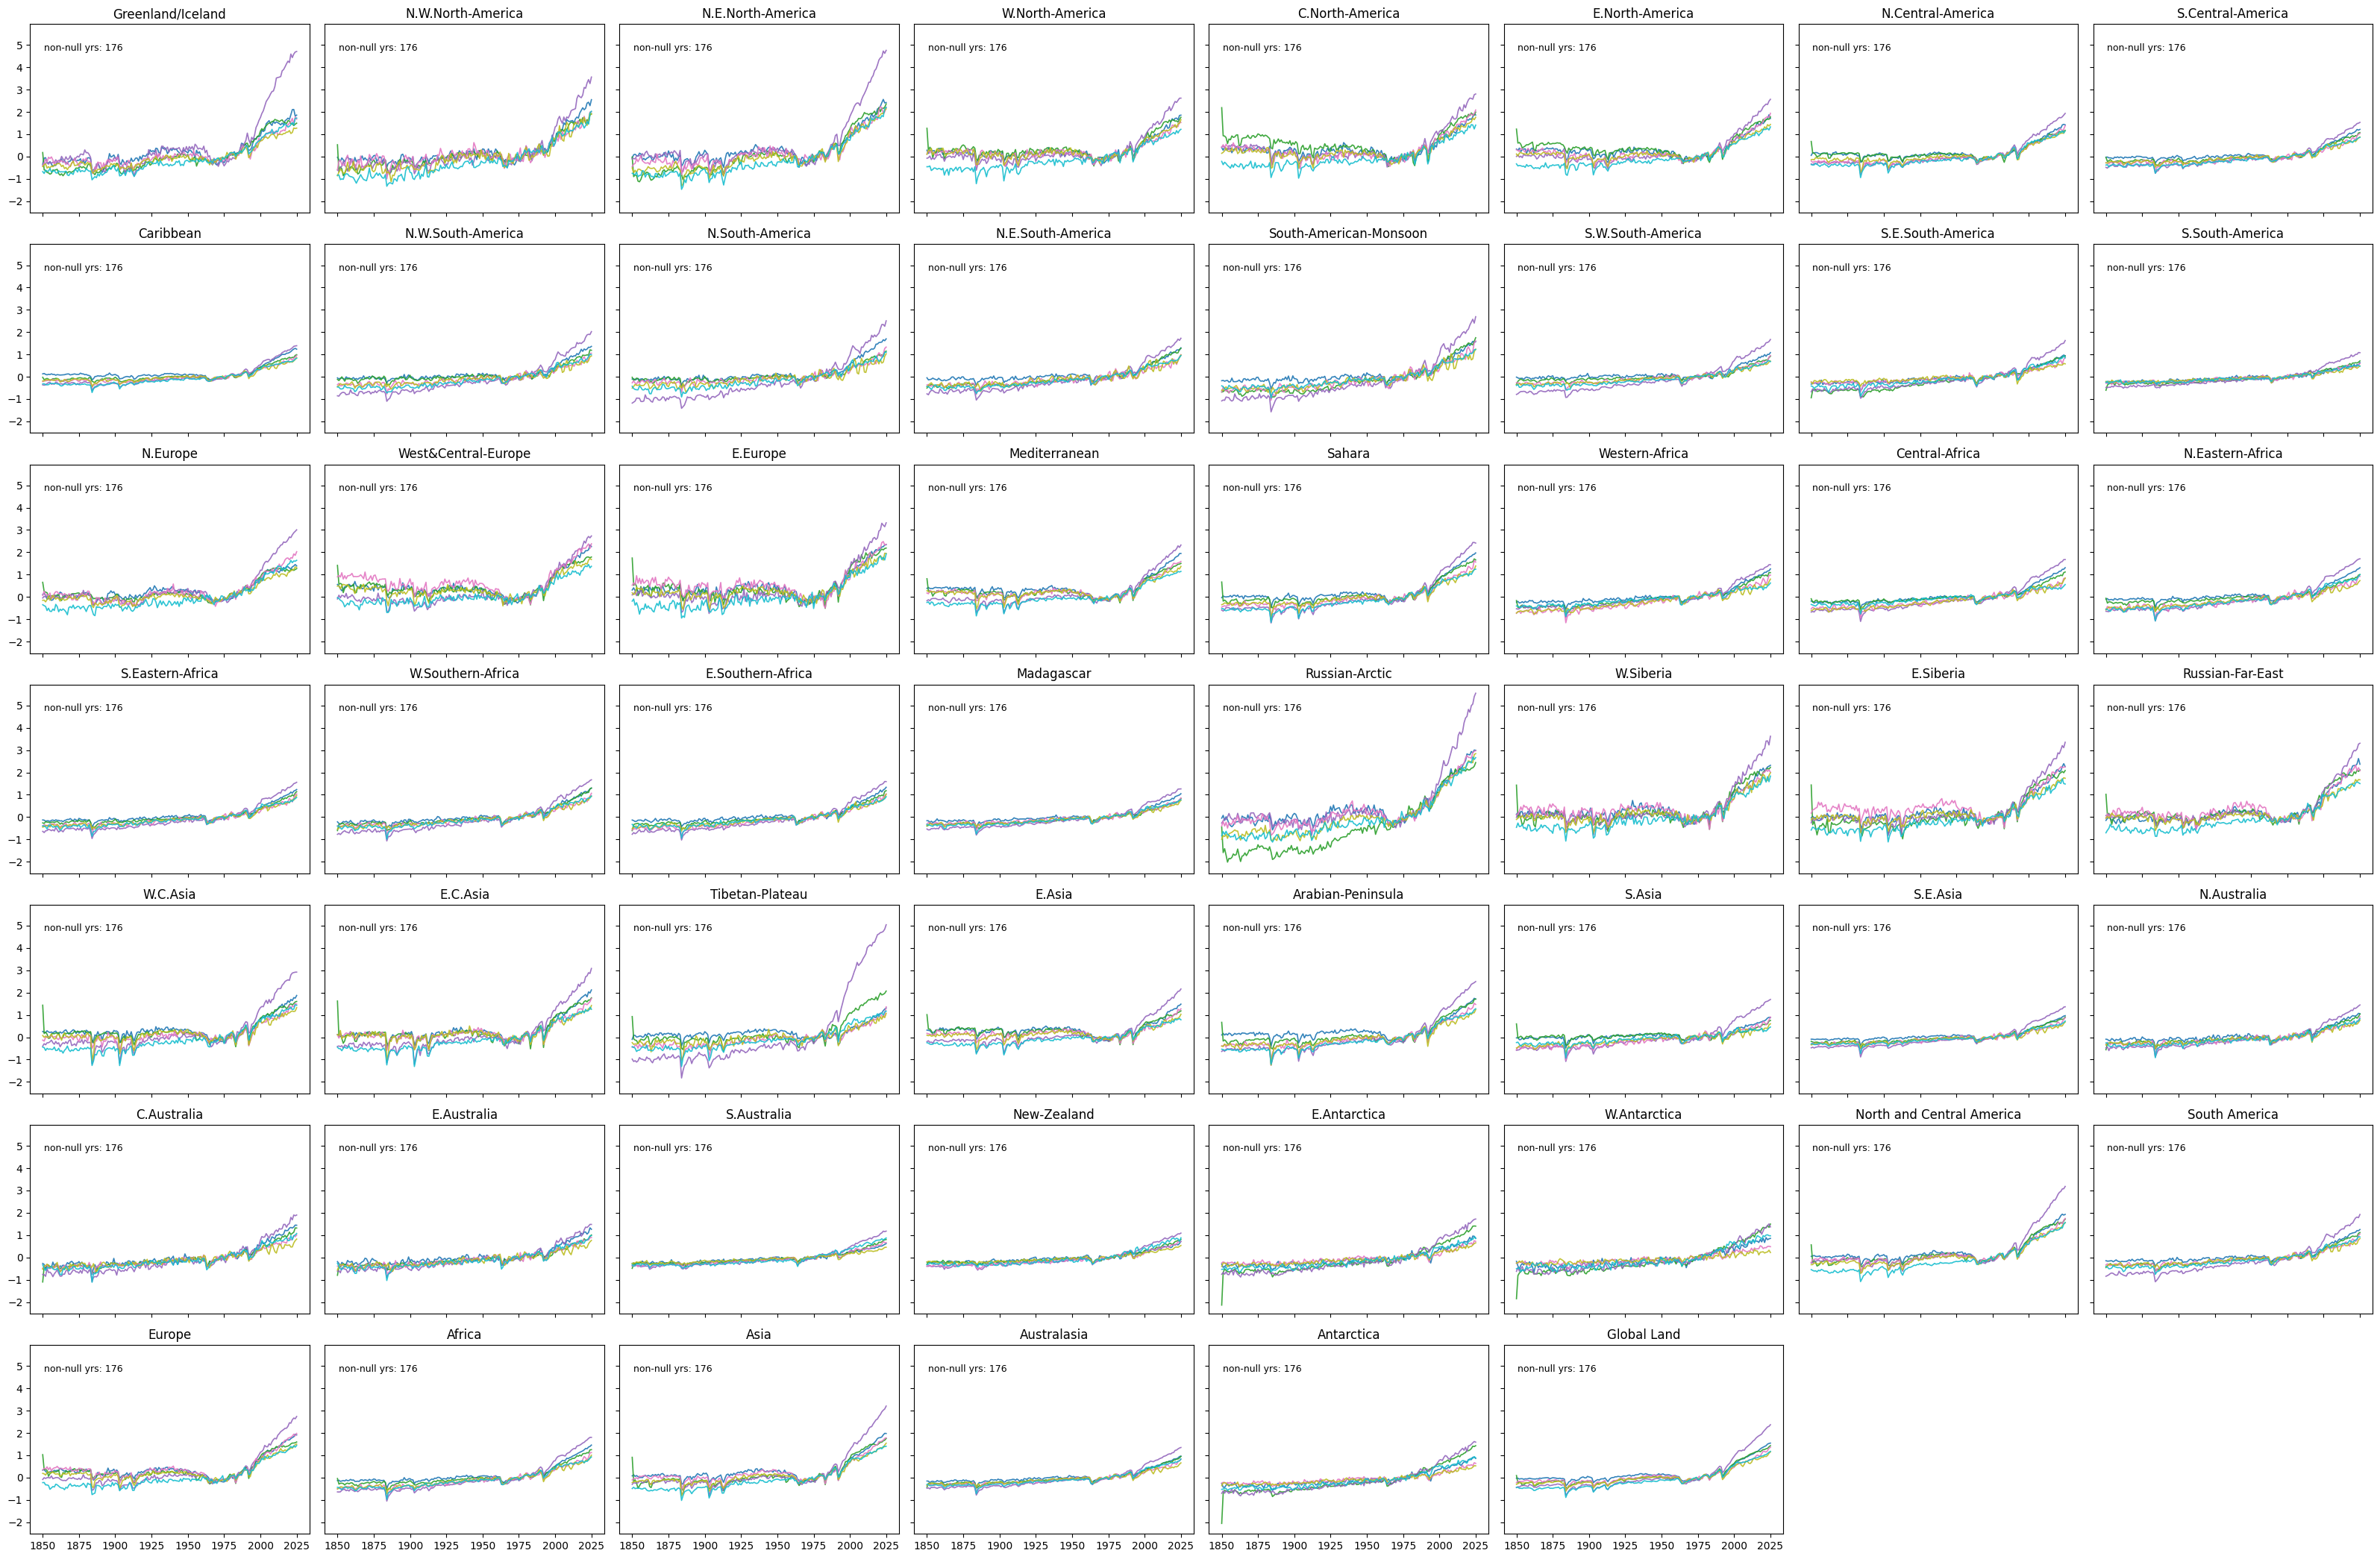

In [41]:
def plot_regional_timeseries_multimodel(
    data, 
    region_coord='region', 
    time_coord='year', 
    model_coord='model_name',   # <—— NEW
    region_names=None, 
    ncols=8, 
    figsize_per_subplot=(4,3), 
    line_width=1.2, 
    yline=None, 
    yline_color='gray', 
    yline_style='--', 
    yline_width=1,
    sharex=True, 
    sharey=True,
    text_pos=(0.05, 0.9),
    cmap='tab10'  # color palette for multiple models
):
    """
    Plot regional time series in a grid of subplots.
    Supports multiple model lines per region if model dimension exists.
    """
    # ----------------------------------------------------
    # Determine if multi-model or single-model data
    # ----------------------------------------------------
    has_models = model_coord in data.dims
    n_models = data.sizes[model_coord] if has_models else 1
    
    # ----------------------------------------------------
    # Setup figure
    # ----------------------------------------------------
    n_regions = data.sizes[region_coord]
    nrows = int(np.ceil(n_regions / ncols))
    
    fig, axes = plt.subplots(
        nrows, ncols, 
        figsize=(ncols * figsize_per_subplot[0], 
                 nrows * figsize_per_subplot[1]),
        sharex=sharex,
        sharey=sharey
    )
    axes = axes.flatten()
    
    # Region names
    if region_names is None:
        region_names = [str(i) for i in range(n_regions)]
    
    # Not-null counts per region
    notnull_counts = data.notnull().sum(dim=time_coord)
    if has_models:
        # for multi-model: count per region across all models
        notnull_counts = notnull_counts.max(dim=model_coord).values
    else:
        notnull_counts = notnull_counts.values

    # Color map
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, n_models))
    
    # ----------------------------------------------------
    # Main loop per region
    # ----------------------------------------------------
    for i in range(n_regions):
        ax = axes[i]
        
        # ----- plot one line per model -----
        if has_models:
            for m in range(n_models):
                data.isel({region_coord: i, model_coord: m}).plot(
                    ax=ax, 
                    color=colors[m], 
                    linewidth=line_width,
                    alpha=0.9
                )
        else:
            data.isel({region_coord: i}).plot(
                ax=ax, color='darkblue', linewidth=line_width
            )
        
        # Optional horizontal lines
        if yline is not None:
            if isinstance(yline, (list, tuple, np.ndarray)):
                for y in yline:
                    ax.axhline(y, color=yline_color, linestyle=yline_style, linewidth=yline_width)
            else:
                ax.axhline(yline, color=yline_color, linestyle=yline_style, linewidth=yline_width)
        
        # Titles + annotation
        ax.set_title(region_names[i])
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        ax.text(
            text_pos[0], text_pos[1], 
            f"non-null yrs: {int(notnull_counts[i])}",
            transform=ax.transAxes,
            fontsize=9, color="black", ha="left", va="top"
        )
    
    # Turn off unused panels
    for j in range(n_regions, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    
    return fig, axes

aa = ln_ar6_cont_global.groupby('model_name').mean().sel(year = slice(1850, 2025))
region_names = aa.coords['names'].values

plot_regional_timeseries_multimodel(aa, region_names = region_names)
plt.show()